# Artifical Neural Netowrks for Solving Ordinary and Partial Differential Equations

by I. E. Lagaris et al.

This notebook replicates the result of [Lagaris et al. 2017)](https://arxiv.org/pdf/physics/9705023.pdf).

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn

# This is useful for taking derivatives:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

## Example 1: Single ODE

Consider the ode:
$$
\frac{d\Psi}{dx} = f(x, \Psi),
$$
with $x \in [0,1]$ and initial conditions (IC):
$$
\Psi(0) = A.
$$
We write the trial solution by:
$$
\Psi_t(x; \theta) = A + x N(x; \theta),
$$
where $N(x; theta)$ is a neural network (NN).
The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left[\frac{d\Psi_t(x;\theta)}{dx} - f(x_i,\Psi_t(x;\theta))\right]^2dx.
$$

In [4]:
# N is a Neural Network - This is exactly the network used by Lagaris et al. 1997
N = nn.Sequential(nn.Linear(1, 10), nn.Sigmoid(), nn.Linear(10,1, bias=False))

# Initial condition
A = 0.

# The Psi_t function
Psi_t = lambda x: A + x * N(x)

# The right hand side function
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

# The loss function
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

loss: 0.4335455000400543
loss: 0.5343429446220398
loss: 0.34412989020347595
loss: 0.31067609786987305
loss: 0.08582349121570587
loss: 0.008198630064725876
loss: 0.0016247667372226715
loss: 0.0012700955849140882
loss: 0.0012624918017536402
loss: 0.0012373499339446425
loss: 0.0008719113538973033
loss: 0.0005360014038160443
loss: 0.0003214187454432249
loss: 0.0003028032660949975
loss: 0.00030005406006239355
loss: 0.00029935460770502687
loss: 0.0002982299483846873
loss: 0.0002977572730742395
loss: 0.00029362665372900665
loss: 0.0002853805781342089
loss: 0.00025270532933063805
loss: 0.03082495927810669
loss: 0.00023714068811386824
loss: 0.00022418840671889484
loss: 8.52536392211914
loss: 0.0001725468027871102
loss: 0.00015735180932097137
loss: 0.00014556446694768965
loss: 0.00013589003356173635
loss: 0.00010127199493581429
loss: 8.925200381781906e-05
loss: 8.751245331950486e-05
loss: 8.63711247802712e-05
loss: 8.28857664600946e-05
loss: 7.501343498006463e-05
loss: 5.958637848380022e-05
loss

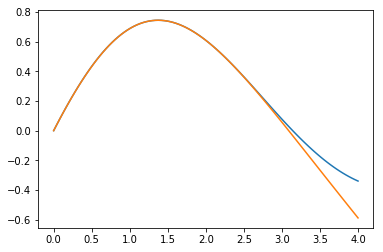

In [5]:
# Optimize (same algorithm as in Lagaris)
optimizer = torch.optim.LBFGS(N.parameters())

# The collocation points used by Lagaris
x = torch.Tensor(np.linspace(0, 2, 10)[:, None])

# Run the optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    print('loss:', l.item())
    l.backward()
    return l
    
for i in range(10):
    optimizer.step(closure)

# Let's compare the result to the true solution
xx = np.linspace(0, 4, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots()
ax.plot(xx, yt)
ax.plot(xx, yy)

In [6]:
# Let's see now if a stochastic optimizer makes a difference
adam = torch.optim.Adam(N.parameters())
n_batch = 1

def closure():
    x = torch.Tensor(2.0 * np.random.rand(n_batch, 1))
    adam.zero_grad()
    l = loss(x)
    #print('loss:', l.item())
    l.backward()
    return l

for i in range(10000):
    if i % 1000 == 999:
        print(i)
    adam.step(closure)

999
1999
2999
3999
4999
5999
6999
7999
8999
9999


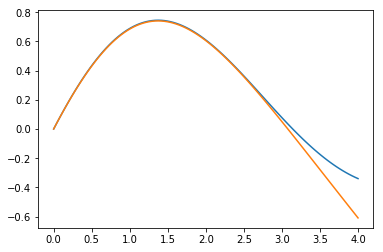

In [7]:
# Let's compare the result to the true solution
xx = np.linspace(0, 4, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots()
ax.plot(xx, yt)
ax.plot(xx, yy)

Let's write some code that will allow us to solve any 1D ODE problem:

In [74]:
class DynamicalSystem(object):
    """
    A class representing an initial value problem.
    
    :param dim:               The dimensionality of the problem.
    :param rhs:               The right hand side of the equation.
                              This must be a function with signature rhs(t, y)
                              where t is time and y is the state of the system.
    :param init_conditions:   Initial conditions. Must be a vector of dimension dim.
    :param net:               A neural network for representing the solution. This must have
                              one-dimensional input and dim-dimensional output.
    """
    
    def __init__(self, dim, rhs, init_conditions, net):
        assert isinstance(dim, int)
        assert dim > 0
        self._dim = dim
        self._rhs = rhs
        if isinstance(init_conditions, float):
            init_conditions = np.atleast_1d(init_conditions)
        init_conditions = torch.Tensor(init_conditions)
        self._init_conditions = init_conditions
        self._net = net
        self._solution = lambda T: self.init_conditions + T * self.net(T)
        
    @property
    def dim(self):
        return self._dim
    
    @property
    def rhs(self):
        return self._rhs
    
    @property
    def init_conditions(self):
        return self._init_conditions
    
    @property
    def net(self):
        return self._net
    
    @property
    def solution(self):
        """
        Return the solution function.
        """
        return self._solution
    
    def squared_residual_loss(self, T):
        """
        Returns the squared residual loss at times T.
        
        :param T:    Must be a 1D torch tensor.
        """
        T.requires_grad = True
        sol = self.solution(T)
        dsol_dt = torch.empty_like(sol)
        for d in range(self.dim):
            go = torch.zeros_like(sol)
            go[:, d] = 1.0
            dsol_dt[:, d] = torch.autograd.grad(sol, T, grad_outputs=go,
                                                create_graph=True)[0][:, 0]
        return torch.mean((dsol_dt - self.rhs(T, sol)) ** 2.)
    
    def solve_lbfgs(self, T_colloc, max_iter=10):
        """
        Solve the problem by minimizing the squared residual loss.
        
        :param T_colloc: The collocation points used to solve the problem.
        """
        optimizer = torch.optim.LBFGS(self.net.parameters())

        # Run the optimizer
        def closure():
            optimizer.zero_grad()
            l = self.squared_residual_loss(T_colloc)
            l.backward()
            return l
    
        for i in range(max_iter):
            optimizer.step(closure)

In [75]:
# Let's use this class with Problem 2 of Lagaris
ex2 = DynamicalSystem(1,
                      lambda t, y: torch.exp(-t / 5.0) * torch.cos(t) - y / 5.0,
                      0.0,
                      nn.Sequential(nn.Linear(1, 10), nn.Sigmoid(), nn.Linear(10,1, bias=False))
                      )
T_colloc = torch.Tensor(np.linspace(0, 2, 20)[:, None])
ex2.solve_lbfgs(T_colloc)

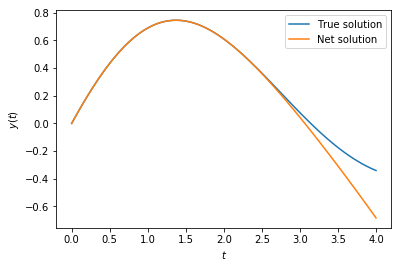

In [76]:
# Now we can evaluate the solution anywhere

T = torch.Tensor(np.linspace(0, 4, 100)[:, None])
sol = ex2.solution(T)
y_true = np.exp(-T / 5.0) * np.sin(T)
fig, ax = plt.subplots()
ax.plot(T.numpy(), y_true.numpy(), label='True solution')
ax.plot(T.numpy(), sol.detach().numpy(), label='Net solution')
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
plt.legend(loc='best')

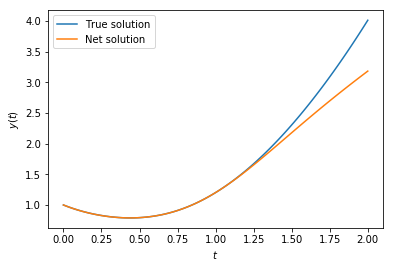

In [77]:
# Here is another problem - Problem 1 of Lagaris
rhs = lambda t, y: t ** 3 + 2 * t + t ** 2 * (1.0 + 3.0 * t ** 2) / (1.0 + t + t ** 3) \
                   -(t + (1.0 + 3.0 * t ** 2) / (1.0 + t + t ** 3)) * y
ex1 = DynamicalSystem(1,
                      rhs,
                      1.0,
                      nn.Sequential(nn.Linear(1, 10), nn.Sigmoid(), nn.Linear(10,1, bias=False))
                      )
T_colloc = torch.Tensor(np.linspace(0, 1, 10)[:, None])
ex1.solve_lbfgs(T_colloc)
T = torch.Tensor(np.linspace(0, 2, 100)[:, None])
sol = ex1.solution(T)
y_true = np.exp( -0.5 * T ** 2) / (1.0 + T + T ** 3) + T ** 2
fig, ax = plt.subplots()
ax.plot(T.numpy(), y_true.numpy(), label='True solution')
ax.plot(T.numpy(), sol.detach().numpy(), label='Net solution')
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
plt.legend(loc='best')

In [78]:
# Let's do a 2D problem - Problem 4 of Lagaris
def rhs(t, y):
    t = torch.flatten(t)
    res = torch.empty_like(y)
    res[:, 0] = torch.cos(t) + y[:, 0] ** 2 + y[:, 1] - (1.0 + t ** 2 + torch.sin(t) ** 2)
    res[:, 1] = 2.0 * t - (1.0 + t ** 2) * torch.sin(t) + y[:, 0] * y[:, 1]
    return res
ex4 = DynamicalSystem(2,
                      rhs,
                      torch.Tensor([0.0, 1.0]),
                      nn.Sequential(nn.Linear(1, 20), nn.Sigmoid(), nn.Linear(20,2, bias=False))
                      )
T_colloc = torch.Tensor(np.linspace(0, 3, 10)[:, None])
ex4.solve_lbfgs(T_colloc, max_iter=20) # Does not work everytime. Sometimes the optimization fails.

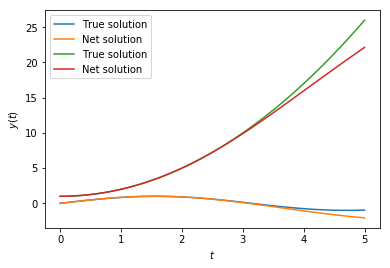

In [79]:
T = torch.Tensor(np.linspace(0, 5, 100)[:, None])
sol = ex4.solution(T)
y1_true = np.sin(T)
y2_true = 1.0 + T ** 2
fig, ax = plt.subplots()
ax.plot(T.numpy(), y1_true.numpy(), label='True solution')
ax.plot(T.numpy(), sol.detach().numpy()[:, 0], label='Net solution')
ax.plot(T.numpy(), y2_true.numpy(), label='True solution')
ax.plot(T.numpy(), sol.detach().numpy()[:, 1], label='Net solution')
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
plt.legend(loc='best')

Now, let's try their approach for PDEs of the form:
$$
\frac{\partial^2}{\partial x^2}\Psi(x,y) + \frac{\partial^2}{\partial y^2}\Psi(x,y) = f(x,y),
$$
on $(x,y) \in [0,1]^2$ with Dirichlet boundary conditions:
$$
\Psi(0, y) = f_0(y),
$$
$$
\Psi(1, y) = f_1(y),
$$
$$
\Psi(x, 0) = g_0(x),
$$
and
$$
\Psi(x, 1) = g_1(x).
$$
We write:
$$
\Psi_t(x,y;\theta) = A(x,y) + x(1-x)y(1-y)N(x,y;\theta),
$$
where $A(x,y)$ is chosen to satisfy the boundary conditions:
$$
A(x,y) = (1-x)f_0(y) + xf_1(y) + (1-y)\{g_0(x) - [(1-x)g_0(0)+xg_0(1)]\} + y\{g_1(x)-[(1-x)g_1(0) + xg_1(1)]\}.
$$
The loss function that we need to minimize is:
$$
L(\theta) = \int_{[0,1]^2} \left\{\frac{\partial^2}{\partial x^2}\Psi(x,y) + \frac{\partial^2}{\partial y^2}\Psi(x,y) = f(x,y)\right\}^2dxdy.
$$

In [80]:
class PDEProblemDC(object):
    """
    A class representing PDE with DC boundary.
    
    :param rhs:               The right hand side of the equation.
                              This must be a function with signature rhs((x,y))
                              where t is time and y is the state of the system.
    :param f0:                Left boundary conditon.
    :param f1:                Right boundary condition.
    :param g0:                Bottom boundary conditon.
    :param g1:                Top boundary condition.
    :param net:               A neural network for representing the solution. This must have
                              two-dimensional input and one-dimensional output.
    """
    
    def __init__(self, rhs, f0, f1, g0, g1, net):
        self._rhs = rhs
        self._f0 = f0
        self._f1 = f1
        self._g0 = g0
        self._g1 = g1
        self._net = net
        # This implements a function that satisfies the boundary conditions exactly
        g00 = self.g0(torch.zeros((1,)))[0]
        g01 = self.g0(torch.ones((1,)))[0]
        g10 = self.g1(torch.zeros((1,)))[0]
        g11 = self.g1(torch.ones((1,)))[0]
        def A(x):
            res = (1.0 - x[:, 0]) * self.f0(x[:, 1])
            res += x[:, 0] * self.f1(x[:, 1])
            res += (1.0 - x[:, 1]) * (self.g0(x[:, 0]) - ((1.0 - x[:, 0]) * g00 + x[:, 0] * g01))
            res += x[:, 1] * (self.g1(x[:, 0]) - ((1.0 - x[:, 0]) * g10 + x[:, 0] * g11))
            return res
        self._A = A
        self._solution = lambda x: self.A(x) + x[:, 0] * (1.0 - x[:, 0]) * x[:, 1] * (1.0 - x[:, 1]) * self.net(x)[:, 0]
    
    @property
    def rhs(self):
        return self._rhs
    
    @property
    def f0(self):
        return self._f0
    
    @property
    def f1(self):
        return self._f1
    
    @property
    def g0(self):
        return self._g0
    
    @property
    def g1(self):
        return self._g1
    
    @property
    def A(self):
        return self._A
    
    @property
    def net(self):
        return self._net
    
    @property
    def solution(self):
        """
        Return the solution function.
        """
        return self._solution
    
    def squared_residual_loss(self, X):
        """
        Returns the squared residual loss at spatial locations X.
        
        :param T:    Must be a 1D torch tensor.
        """
        X.requires_grad = True
        sol = self.solution(X)
        A = self.A(X)
        sol_x = grad(sol, X)
        # Get the second derivatives
        sol_xx = grad(sol_x[:, 0], X)[:, 0]
        sol_yy = grad(sol_x[:, 1], X)[:, 1]
        rhs = self.rhs(X)
        return torch.mean((sol_xx + sol_yy - rhs) ** 2)
    
    def solve_lbfgs(self, X_colloc, max_iter=10):
        """
        Solve the problem by minimizing the squared residual loss.
        
        :param T_colloc: The collocation points used to solve the problem.
        """
        optimizer = torch.optim.LBFGS(self.net.parameters())

        # Run the optimizer
        def closure():
            optimizer.zero_grad()
            l = self.squared_residual_loss(X_colloc)
            l.backward()
            return l
        for i in range(max_iter):
            res = optimizer.step(closure)
            print(res)
            

def plot_contour(ex, true_sol):
    xx = np.linspace(0, 1, 64)
    X, Y = np.meshgrid(xx, xx)
    X_flat = torch.Tensor(np.hstack([X.flatten()[:, None], Y.flatten()[:, None]]))
    Z_flat = ex.solution(X_flat).detach().numpy()
    Z_t_flat = true_sol(X_flat)
    Z_t_flat = Z_t_flat.detach().numpy()
    Z = Z_flat.reshape(64, 64)
    Z_t = Z_t_flat.reshape(64, 64)
    fig, ax = plt.subplots()
    c = ax.contourf(X, Y, Z)
    plt.colorbar(c)
    fig, ax = plt.subplots()
    c = ax.contourf(X, Y, Z_t)
    plt.colorbar(c)

In [81]:
# Problem 5 of Lagaris
rhs = lambda x: torch.exp(-x[:, 0]) * (x[:, 0] - 2.0 + x[:, 1] ** 3 + 6.0 * x[:, 1])
f0 = lambda x2: x2 ** 3
f1 = lambda x2: (1.0 + x2 ** 3) * np.exp(-1.0)
g0 = lambda x1: x1 * torch.exp(-x1)
g1 = lambda x1: torch.exp(-x1) * (x1 + 1.0)
ex5 = PDEProblemDC(rhs, f0, f1, g0, g1,
                   nn.Sequential(nn.Linear(2, 10), nn.Sigmoid(), nn.Linear(10,1, bias=False)))
x = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, x)
X_flat = torch.Tensor(np.hstack([X.flatten()[:, None], Y.flatten()[:, None]]))
ex5.solve_lbfgs(X_flat)

tensor(0.0663, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.0699e-05, grad_fn=<MeanBackward0>)
tensor(1.8027e-06, grad_fn=<MeanBackward0>)
tensor(8.5007e-07, grad_fn=<MeanBackward0>)
tensor(1.9530e-06, grad_fn=<MeanBackward0>)
tensor(3.6752e-07, grad_fn=<MeanBackward0>)
tensor(3.6752e-07, grad_fn=<MeanBackward0>)
tensor(3.6752e-07, grad_fn=<MeanBackward0>)
tensor(3.6752e-07, grad_fn=<MeanBackward0>)


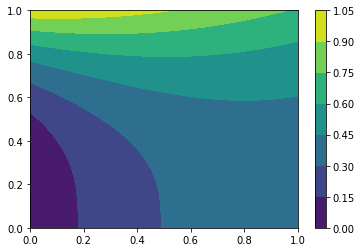

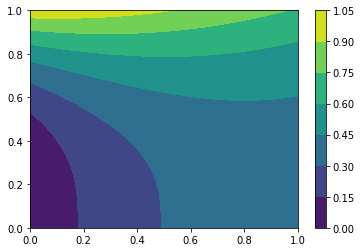

In [82]:
ex5_true_sol = lambda x: torch.exp(-x[:, 0]) * (x[:, 0] + x[:, 1] ** 3)
plot_contour(ex5, ex5_true_sol)

In [88]:
# Problem 6 of Lagaris
a = 3.0
def rhs(x):
    tmp1 = torch.exp(-(a * x[:, 0] + x[:, 1]) / 5.0)
    tmp2 = (-4.0 / 5.0 * a ** 3 * x[:, 0] - 2.0 / 5.0 + 2.0 * a ** 2) * torch.cos(a ** 2 * x[:, 0] ** 2 + x[:, 1])
    tmp2 += (1.0 / 25.0 - 1.0 - 4.0 * a ** 4 * x[:, 0] ** 2 + a ** 2 / 25.0) * torch.sin(a ** 2 * x[:, 0] ** 2 + x[:, 1])
    return tmp1 * tmp2
ex6_true_sol = lambda x: torch.exp(-(a * x[:, 0] + x[:, 1]) / 5.0) * torch.sin(a ** 2 * x[:, 0] ** 2 + x[:, 1])
f0 = lambda x2: ex6_true_sol(torch.stack((torch.zeros_like(x2), x2), dim=1))
f1 = lambda x2: ex6_true_sol(torch.stack((torch.ones_like(x2), x2), dim=1))
g0 = lambda x1: ex6_true_sol(torch.stack((x1, torch.zeros_like(x1)), dim=1))
g1 = lambda x1: ex6_true_sol(torch.stack((x1, torch.ones_like(x1)), dim=1))
net = nn.Sequential(nn.Linear(2, 10), nn.Sigmoid(), nn.Linear(10, 1, bias=False))
ex6 = PDEProblemDC(rhs, f0, f1, g0, g1, net)
x = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, x)
X_flat = torch.Tensor(np.hstack([X.flatten()[:, None], Y.flatten()[:, None]]))
ex6.solve_lbfgs(X_flat, max_iter=10) # Does not always work

tensor(28.7162, grad_fn=<MeanBackward0>)
tensor(28.6921, grad_fn=<MeanBackward0>)
tensor(28.6812, grad_fn=<MeanBackward0>)
tensor(19.6109, grad_fn=<MeanBackward0>)
tensor(6.3334, grad_fn=<MeanBackward0>)
tensor(1.3209, grad_fn=<MeanBackward0>)
tensor(0.2367, grad_fn=<MeanBackward0>)
tensor(0.0365, grad_fn=<MeanBackward0>)
tensor(0.0297, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)


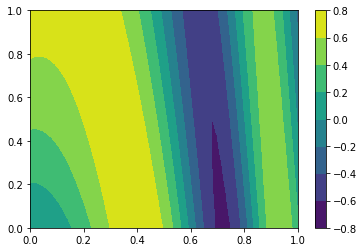

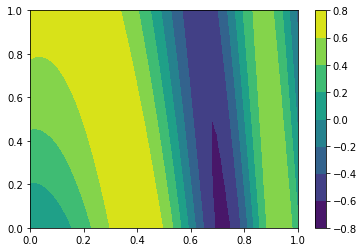

In [90]:
plot_contour(ex6, ex6_true_sol)